# Extract Standalone HSPF Results

Currently this is just the comparison of the "gauge" record, simulated discharge from Reach #5, and external inflows which represent Dolan Creek spring discharge

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon, Point
import pickle
import matplotlib.tri as tri
import datetime as dt
from copy import deepcopy

In [3]:
import flopy

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


In [4]:
# Absolute path to HSPF and associated parameters
HSPF_Dir = r'C:\Users\nmartin\Documents\LOCA\Test_Models\Initial_12_HRU_HSP2'
HSPF_HDF5 = "DC_Subs_12_mHSP2_PreAutoCal.h5"
GAUGE_XLSX = r'C:\Working\Test_Models\Coupled_HSPF\DolanProcessed_Hr-Processed.xlsx'
GAUGE_SHT = "Daily"
GAUGE_HDR = "Discharge_cfs"

In [31]:
# Absolute path to Modflow 6 directory
MF6_Dir = r'C:\Working\Test_Models\Standalone_MF6'
# Name of Modflow 6 Model
MF6_Root = r"DC_MF6"

In [6]:
OUT_DIR = r'C:\Users\nmartin\Documents\BRATWURST\EAA\Images_Figures'

In [7]:
ConvAFDtoCFS = lambda AFD: ( AFD * ( 43560.0 / 1.0**2 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 
ConvAFtoCM = lambda AF: AF * 1233.48185532
ConvCMDtoCFS = lambda CMD: ( CMD * ( 35.3147 / 1.0**3 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 

In [8]:
CStart_DT = dt.datetime( 2013, 7, 1 )
CEnd_DT = dt.datetime( 2018, 7, 1 )

## Load Simulation Results and Data

Load the HSPF results from the HDF5 file

In [9]:
InStore = os.path.normpath( os.path.join( HSPF_Dir, HSPF_HDF5 ) )
with pd.HDFStore( InStore ) as store:
    H_RR5 = store.get(key=r'/RESULTS/RCHRES_R005/HYDR/')
# end with and close the file

In [10]:
H_RR5["ovol_cfs"] = H_RR5.apply( lambda row: ConvAFDtoCFS( row["OVOL1"] ), axis=1 )

In [11]:
H_RR5 = H_RR5.loc[CStart_DT:CEnd_DT].copy()

In [12]:
display( HTML( H_RR5.describe().to_html() ) )

,DEP,IVOL,O1,OVOL1,PRSUPY,RO,ROVOL,SAREA,VOL,VOLEV,ovol_cfs
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,2.632121,33.746521,16.869957,33.461037,0.188525,16.869957,33.461037,33.618977,267.380920,0.474163,16.869944
std,0.144616,58.414692,29.149939,57.818069,0.723034,29.149939,57.818069,0.149396,4.848168,0.163547,29.149947
min,2.392789,20.919632,10.516840,20.859848,0.000000,10.516840,20.859848,33.363903,259.454681,0.109930,10.516840
25%,2.569578,26.214437,13.061897,25.907894,0.000000,13.061897,25.907894,33.553736,265.295837,0.315917,13.061897
50%,2.622063,27.919107,13.820251,27.412069,0.000000,13.820251,27.412069,33.610092,267.036346,0.521484,13.820252
75%,2.661324,30.775544,15.400058,30.545570,0.000090,15.400058,30.545570,33.650696,268.339951,0.618408,15.400058
max,4.380620,1979.299194,992.713867,1969.019287,9.264581,992.713867,1969.019287,35.396580,326.925293,0.777007,992.713891


In [13]:
H_DSprings = pd.read_hdf( InStore, key=r'/TIMESERIES/TS136/')

In [14]:
type(H_DSprings)

pandas.core.series.Series

In [15]:
H_DSprings.index[:5]

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

In [16]:
H_DSprings.values

array([24.23140526, 24.66425705, 24.33006287, ..., 24.11570168,
       25.17148781, 25.34090996])

Make a DataFrame

In [18]:
DataDict = { "ExtIn_afd" : np.array( H_DSprings.values, dtype=np.float32 ), }
H_RR5_ExIn = pd.DataFrame( index=H_DSprings.index, data=DataDict )

In [19]:
H_RR5_ExIn["ovol_cfs"] = H_RR5_ExIn.apply( lambda row: ConvAFDtoCFS( row["ExtIn_afd"] ), axis=1 )

In [20]:
H_RR5_ExIn = H_RR5_ExIn.loc[CStart_DT:CEnd_DT].copy()

In [21]:
display( HTML( H_RR5_ExIn.describe().to_html() ) )

,ExtIn_afd,ovol_cfs
count,1827.000000,1827.000000
mean,24.903486,12.555510
std,2.118830,1.068243
min,20.290186,10.229635
25%,23.395868,11.795417
50%,24.686466,12.446093
75%,25.945765,13.080990
max,32.033058,16.150000


Make continuous lists so that can use "fill"

In [22]:
lenBF = len( H_RR5_ExIn )
lenBF

1827

In [23]:
DTTimeList = list( H_RR5_ExIn.index.to_pydatetime() )
type(DTTimeList)

list

In [24]:
BackDTList = deepcopy( DTTimeList )
BackDTList = BackDTList[::-1]
BackDTList[:5]

[datetime.datetime(2018, 7, 1, 0, 0),
 datetime.datetime(2018, 6, 30, 0, 0),
 datetime.datetime(2018, 6, 29, 0, 0),
 datetime.datetime(2018, 6, 28, 0, 0),
 datetime.datetime(2018, 6, 27, 0, 0)]

In [25]:
ZeroVals = [ 0.0 for x in range( lenBF ) ]
DSVals = list( H_RR5_ExIn["ovol_cfs"].to_numpy() )
DSVals = DSVals[::-1]
DSVals[:5]

[12.699999952316283,
 13.244531647364298,
 12.563542000452676,
 12.30234345595042,
 12.017825587590535]

In [26]:
ValsList = deepcopy( ZeroVals )
ValsList.extend( DSVals )
DTTimeList.extend( BackDTList )

Load the gauge data

In [27]:
DCGauge = pd.read_excel( GAUGE_XLSX, sheet_name=GAUGE_SHT, header=0, index_col=0, parse_dates=True )

C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [28]:
DCGauge = DCGauge[[GAUGE_HDR]].loc[CStart_DT:CEnd_DT].copy()

In [29]:
display( HTML( DCGauge.describe().to_html() ) )

,Discharge_cfs
count,1827.000000
mean,14.924813
std,4.637589
min,8.030938
25%,11.859896
50%,13.535417
75%,16.627604
max,44.078827


## Plots

In [ ]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "HSPF_SA_Calib.svg" ) )
OutSVG

In [ ]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "HSPF_SA_Calib.png" ) )
OutPNG

In [ ]:
disTicks = [ 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0 ]

In [ ]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Dcg, = ax11.plot( DCGauge.index, DCGauge[GAUGE_HDR], color='xkcd:ocean blue', linewidth=2,
                  label="Dolan Creek Gauge" )
Rc5, = ax11.plot( H_RR5.index, H_RR5["ovol_cfs"], color='xkcd:burnt orange', linewidth=2,
                  label="HSPF Reach #5 Outflow (simulated gauge discharge)" )
sfF = ax11.fill( DTTimeList, ValsList, color='xkcd:pale orange', alpha=0.5, 
                 label="HSPF Reach #5 Specified External Inflow Timeseries (Dolan Springs Discharge)")
#ax11.legend( (Dcg, Rc5 ), 
#             ("Dolan Creek Gauge", "Simulated Reach 5 outflow" ),
#             loc='upper center', fontsize=12)
ax11.legend(loc='upper left')
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 2000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Dolan Creek Discharge (cfs)', fontsize=12)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

## MODFLOW 6 Steady-State

In [32]:
DRNIn_Path = os.path.join( MF6_Dir, "Outputs" ,r'SA_Calib-DRN_Budget.xlsx' )
DRN_DF = pd.read_excel( DRNIn_Path, sheet_name="Sheet1", header=0, index_col=0, parse_dates=True )

C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [33]:
display( HTML( DRN_DF.head().to_html() ) )

,time,FINEGAN,704,703,DOLAN,701,Rch5_Spring,Outside,DS_cfs
2013-01-01,1,-106.32,-12.776,-11.175,-15331,-17887,-33218,-130.271,-13.577358
2013-01-02,2,-106.28,-12.774,-11.172,-15332,-17891,-33223,-130.226,-13.579401
2013-01-03,3,-106.25,-12.775,-11.171,-15333,-17893,-33226,-130.196,-13.580628
2013-01-04,4,-106.33,-12.791,-11.184,-15333,-17896,-33229,-130.305,-13.581854
2013-01-05,5,-106.32,-12.797,-11.187,-15334,-17899,-33233,-130.304,-13.583489


In [34]:
DRN_DF = DRN_DF.loc[CStart_DT:CEnd_DT].copy()

In [35]:
lenDRN = len( DRN_DF )
lenDRN

1827

In [36]:
DTTimeList = list( DRN_DF.index.to_pydatetime() )
type(DTTimeList)

list

In [37]:
BackDTList = deepcopy( DTTimeList )
BackDTList = BackDTList[::-1]
BackDTList[:5]

[datetime.datetime(2018, 7, 1, 0, 0),
 datetime.datetime(2018, 6, 30, 0, 0),
 datetime.datetime(2018, 6, 29, 0, 0),
 datetime.datetime(2018, 6, 28, 0, 0),
 datetime.datetime(2018, 6, 27, 0, 0)]

In [38]:
ZeroVals = [ 0.0 for x in range( lenDRN ) ]
DSVals = list( -1.0 * DRN_DF["DS_cfs"].to_numpy() )
DSVals = DSVals[::-1]
DSVals[:5]

[13.53484925694445,
 13.53525799189815,
 13.53525799189815,
 13.53566672685185,
 13.53566672685185]

In [39]:
ValsList = deepcopy( ZeroVals )
ValsList.extend( DSVals )
DTTimeList.extend( BackDTList )

In [44]:
disTicks = [ 5.0, 10.0, 50.0, 100.0 ]

In [45]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "MF6_SA_DC_Calib.svg" ) )
OutSVG

'C:\\Users\\nmartin\\Documents\\BRATWURST\\EAA\\Images_Figures\\MF6_SA_DC_Calib.svg'

In [46]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "MF6_SA_DC_Calib.png" ) )
OutPNG

'C:\\Users\\nmartin\\Documents\\BRATWURST\\EAA\\Images_Figures\\MF6_SA_DC_Calib.png'

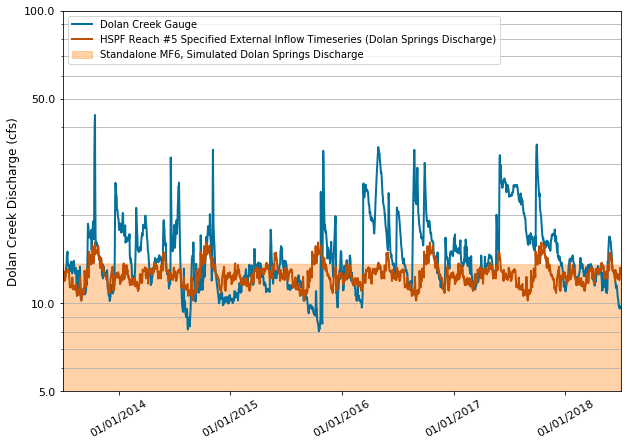

In [47]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Dcg, = ax11.plot( DCGauge.index, DCGauge[GAUGE_HDR], color='xkcd:ocean blue', linewidth=2,
                  label="Dolan Creek Gauge" )
Rc5, = ax11.plot( H_RR5_ExIn.index, H_RR5_ExIn["ovol_cfs"], color='xkcd:burnt orange', linewidth=2,
                  label="HSPF Reach #5 Specified External Inflow Timeseries (Dolan Springs Discharge)" )
sfF = ax11.fill( DTTimeList, ValsList, color='xkcd:pale orange', alpha=0.5, 
                 label="Standalone MF6, Simulated Dolan Springs Discharge")
ax11.legend(loc='upper left')
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 100.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Dolan Creek Discharge (cfs)', fontsize=12)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )